# Week 14
# Ensemble Learning and Data Dimension Reduction

*Readings: Chapter 7, 8*

## Ensemble Learning

The goal of ensemble learning is to combine the predictions of several base estimators in order to improve generalizability and robustness

>**Wisdom of the crowd:** the collective opinion of a group of individuals is often better than that of a single expert.

### Popular Ensemble methods
- Build several estimators *independently* and then average their predictions. On average, the combined estimator is usually better than any of the single base estimator.

**Examples:** Bagging, random forests.
- Build several estimators *sequentially* with each new one trying to reduce the bias of the previous estimators.

**Examples:** AdaBoost, Gradient Boost, XGBoost
- Build a model to aggregate the predictions of several other models. The second-level model learns to highlight where each base estimator performs best and discredit where it performs poorly.

**Examples** Stacking, *neural networks*

Let's use the moon dataset to illustrate the power of ensemble methods

In [1]:
# Create a moon-shape dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.3)

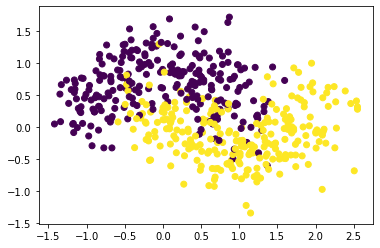

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:500,1], c=y)
plt.show()

### Model 1: A single decision tree

In [3]:
# Split the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [4]:
# Apply a Decision Tree model to build a classifier
from sklearn.tree import DecisionTreeClassifier
tree_clas = DecisionTreeClassifier(max_depth = 5)
tree_clas.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [5]:
# Calculate the accuracy score on test set
from sklearn.metrics import accuracy_score
y_test_pred = tree_clas.predict(X_test) # predict y value for test set
score = accuracy_score(y_test, y_test_pred)
print(score)

0.84


In [6]:
# Visualize the decision boundary
def plot_decision_boundary(model, X, y):
    padding=0.1
    res=0.01
    
    x_min,x_max=X[:,0].min(), X[:,0].max()
    y_min, y_max=X[:,1].min(), X[:,1].max()
    
    x_range=x_max-x_min
    y_range=y_max-y_min
    
    xx,yy= np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))
    
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx,yy,Z, cmap=plt.cm.Accent)
    
    plt.scatter(X[:,0], X[:,1],s=35,c=y,cmap=plt.cm.cool)

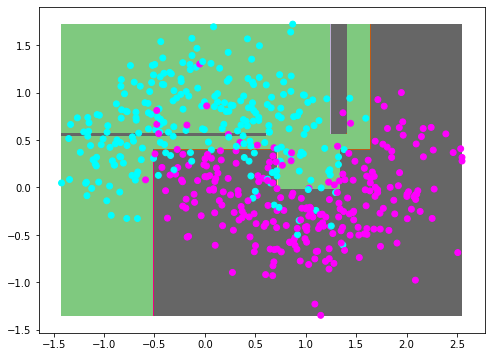

In [7]:
plot_decision_boundary(tree_clas,X,y)

### Model 2: Combining decision tree, logistic regression, and linear SVM

Let's train three classifiers and let them vote for the final decision

In [9]:
# Import classifiers
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

lr_clf = LogisticRegression(solver='lbfgs')
svm_clf = SVC(gamma='auto')
dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators=[('lr', lr_clf),
                ('svm', svm_clf),
                ('dt', dt_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_...
                                  verbose=False)),
                             ('dt',
                       

In [10]:
# Calculate accuracy score for each model
for clf in (lr_clf, svm_clf, dt_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    print(clf.__class__.__name__, 
          accuracy_score(y_test, y_test_pred))

LogisticRegression 0.85
SVC 0.89
DecisionTreeClassifier 0.81
VotingClassifier 0.89


### Model 3: Bagging and Pasting
Another approach is to use the same training algorithm for every classifier, but to train them on different random subsets of the training set.
- When sampling is performed *with* replacement, this method is called **bagging**.
- When sampling is performed *without* replacement, it is called **pasting**.

Bagging and pasting allow training instances to be sampled several times across multiple classifiers, but only bagging allows training instances to be sampled several times for the same classifier.

Once all base models are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all models. The aggregation is typically the **majority vote** for classification, or the **average** for regression.

In [11]:
# Build an ensemble of 500 decision trees
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [12]:
# Compute accuracy score
y_test_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))

0.9


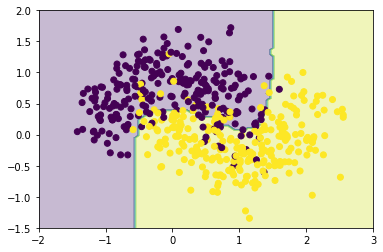

In [13]:
# Visualize the decision boundary
X1 = np.linspace(-2, 3, 100)
X2 = np.linspace(-1.5, 2, 100)
X1_mesh, X2_mesh = np.meshgrid(X1, X2)
X_new = np.c_[X1_mesh.ravel(), X2_mesh.ravel()]

y_pred = bag_clf.predict(X_new).reshape(X1_mesh.shape)

plt.contourf(X1,
             X2,
             y_pred,
             alpha=0.3)

plt.scatter(X[:, 0], X[:, 1], c=y)

# Boosting

Boosting refers to Ensemble methods that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

## AdaBoost
AdaBoost, short for *Adaptive Boosting*, is a boosting methods where each predictor is trained with more attention to the training instances that its predecessor underfitted.

### AdaBoost algorithm
- Train a base classifier (such as a Decision Tree)
- Calculate the accuracy of the base classifier and find all misclassified training instances
- Increase the weights of the misclassified training instances
- Train a second base classifier
- Repeat Step 2-4

The **weight** of a training instance refers to the factor of its error term in the cost function.

Once all predictors are trained, the ensemble makes predictions by taking votes from each base predictor. Unlike bagging/pasting methods, predictors have different weights depending on their overall accuracy on the weighted training set.

## Gradient Boosting
Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration, this method tries to fit the new predictor to the *residual errors* made by the previous predictor

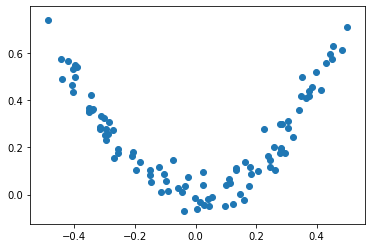

In [14]:
# Create dataset for regression
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)
plt.scatter(X, y)
plt.show()

In [15]:
# Build a base Decision Tree regressor
from sklearn.tree import DecisionTreeRegressor
dt1 = DecisionTreeRegressor(max_depth=2)
dt1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

No handles with labels found to put in legend.


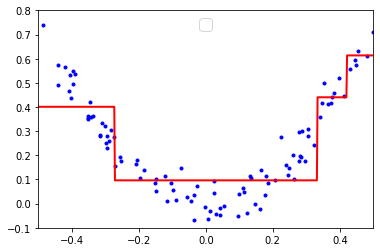

In [16]:
# Visualize the regression line

def plot_predictions(regressors,
                     X,
                     y,
                     axes,
                     label=None,
                     style='r-',
                     data_label=None,
                     data_style='b.'):
    # Create a input array
    x1 = np.linspace(axes[0], axes[1], 500)
    
    # Obtain model prediction
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))\
                 for regressor in regressors)
    
    # Plot data points
    plt.plot(X[:, 0], y, data_style, label=data_label)
    
    # Plot regression line
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    
    plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

plot_predictions([dt1], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8])

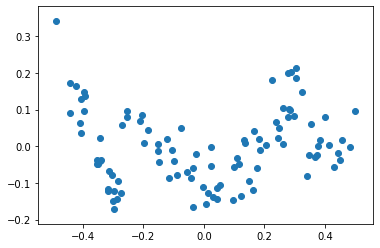

In [17]:
# Calculate the residual errors made by this regressor
y2 = y - dt1.predict(X)
plt.scatter(X, y2)
plt.show()

In [18]:
# Build another Decision Tree to fit y2
dt2 = DecisionTreeRegressor(max_depth=2)
dt2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

No handles with labels found to put in legend.


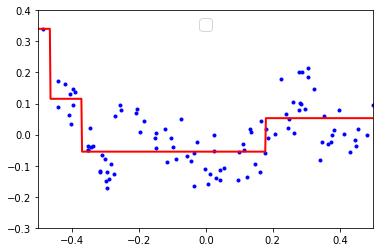

In [19]:
# Visualize the second regressor
plot_predictions([dt2], X, y2,
                 axes=[-0.5, 0.5, -0.3, 0.4])

No handles with labels found to put in legend.


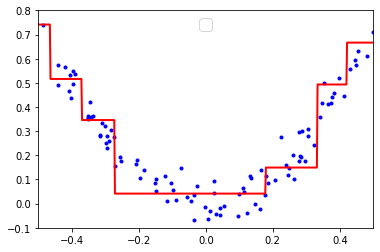

In [20]:
# Visualize the ensemble
plot_predictions([dt1, dt2], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8])

### Gradient Boosting using sklearn

No handles with labels found to put in legend.


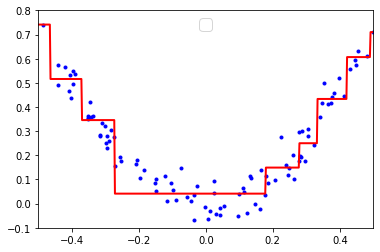

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(max_depth=2,
                                  n_estimators=3,
                                  learning_rate=1.0)
model.fit(X, y)
plot_predictions([model], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

- learning_rate shrinks the contribution of each tree, reducing model overfitting
- subsample: limiting the fraction of samples to be used for fitting each individual tree.

## Stacking

Stacking is based on a simple idea: instead of using trivial function (such as hard voting), why don't we train a model to aggregate the predictions of all base predictors? A common approach is to split the training set into two subsets. The first subset is used to train each base predictors, and the second subset is used to train the *meta learner*.

### Stacking algorithm
- Split the training set into $S_1$ and $S_2$.
- Train each base predictor by fitting it to $S_1$.
- Record the prediction of each base predictor on $S_2$.
- Use these predictions as input, train the meta learner.

# Dimensionality Reduction

Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution. This problem is often referred to as the **curse of dimensionality**.

Fortunately, it is often possible to reduce the number of features considerably, turning an intractable problem into a tractable one. This procedure is called **dimensionality reduction**. 

### Main approaches for dimensionality reduction
- Projection: remove features which have little variation.
- Manifold learning: Use a few parameters to describe the dataset.
- Principal Component Analysis (PCA): use matrix decomposition techniques to find the most important feature combinations.

In [27]:
# Load the training set and show its first 5 rows.
import pandas as pd
path = "C:\\Users\\ch002\\Dropbox\\Teaching\\CMP414\\Data\\mnist-in-csv\\"
filename = "mnist_train.csv"
raw_data = pd.read_csv(path + filename, delimiter = ',')
X = raw_data.iloc[:, 1:].to_numpy()
y = raw_data.iloc[:, 0].to_numpy()

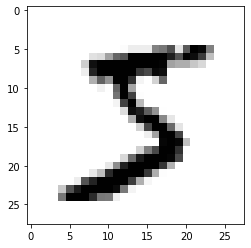

In [28]:
import matplotlib.pyplot as plt
plt.imshow(X[0, :].reshape(28, 28),
           cmap=plt.cm.binary)
plt.show()

In [29]:
# use PCA to reduce the number of features
from sklearn.decomposition import PCA

pca = PCA(n_components=150)
X_reduced = pca.fit_transform(X)

print('X shape:', X.shape)
print('X_reduced shape:', X_reduced.shape)

X shape: (60000, 784)
X_reduced shape: (60000, 150)


In [30]:
# Recover the data from compressed representation
X0 = pca.inverse_transform(X_reduced[0])

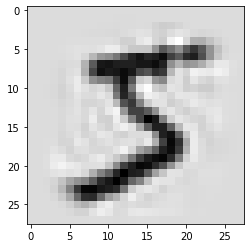

In [31]:
# Display the recovered image
plt.imshow(X0.reshape(28, 28),
           cmap=plt.cm.binary)
plt.show()

# Course Summary

## Python libraries
- numpy
- pandas
- matplotlib
- seaborn
- sklearn
- tensorflow

## Models
- Linear regression
- Polynomial regression
- Logistic regression
- K-nearest neighbour
- Support Vector Machine
- Neural Network
- Decision Tree
- Random Forest
- Clustering methods
- Bagging
- Boosting
- Stacking
- Principle component analysis

## Data processing/visualization techniques
- Data cleaning
- Missing data imputation
- Dimensionality reduction
- Descriptive statistics (mean, median, variation, std)
- Histogram
- Scattor plot
- Confusion matrix
- ROC curve and AUC
- Decision boundary
- Regression line

## Model validation/fine tuning
- Cross validation
- Regularization (L1, L2, Elastic Net)
- Grid search
- Random search